# Breast Cancer Survival Analysis and Risk Prediction using METABRIC Dataset

Develop comprehensive survival analysis models and a robust machine learning model to accurately predict 10-year mortality risk for breast cancer patients. By utilizing these models, the institute aims to improve treatment planning, patient counselling, and overall cancer care strategies.

### Project Overview:
This project aims to deepen the understanding of breast cancer survival trends and enhance prediction models for patient outcomes. By leveraging advanced statistical techniques and machine learning, the project seeks to analyze survival rates and accurately predict the 10-year mortality risk for breast cancer patients. The ultimate objective is to improve treatment planning, patient counseling, and overall cancer care strategies.

### Project Walkthrough:
1. **Data Exploration**
   - Comprehensive EDA with visualizations
   - Missing value analysis
   - Outlier detection and handling

2. **Feature Engineering**
   - Handle missing values appropriately
   - Scale numerical variables
   - Encode categorical variables
   - Feature selection based on clinical relevance

3. **Survival Analysis**
   - Kaplan-Meier survival curves
   - Cox Proportional Hazards models
   - Stratified analysis by key factors

4. **Model Development**
   - Logistic Regression
   - SVM
   - Decision Trees
   - Performance evaluation using ROC-AUC

5. **Results Visualization**
   - Survival curves
   - Feature importance plots
   - Model performance metrics


✅ Import Required Libraries

In [28]:
# --- 1. Import Required Libraries ---

# Core data science and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math

# Sklearn tools for ML pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score, f1_score
from sklearn.impute import SimpleImputer

# Survival analysis
from lifelines import KaplanMeierFitter, CoxPHFitter

# Serialization
import joblib

# Set default styles and suppress warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="deep")


✅ Load and Clean Data

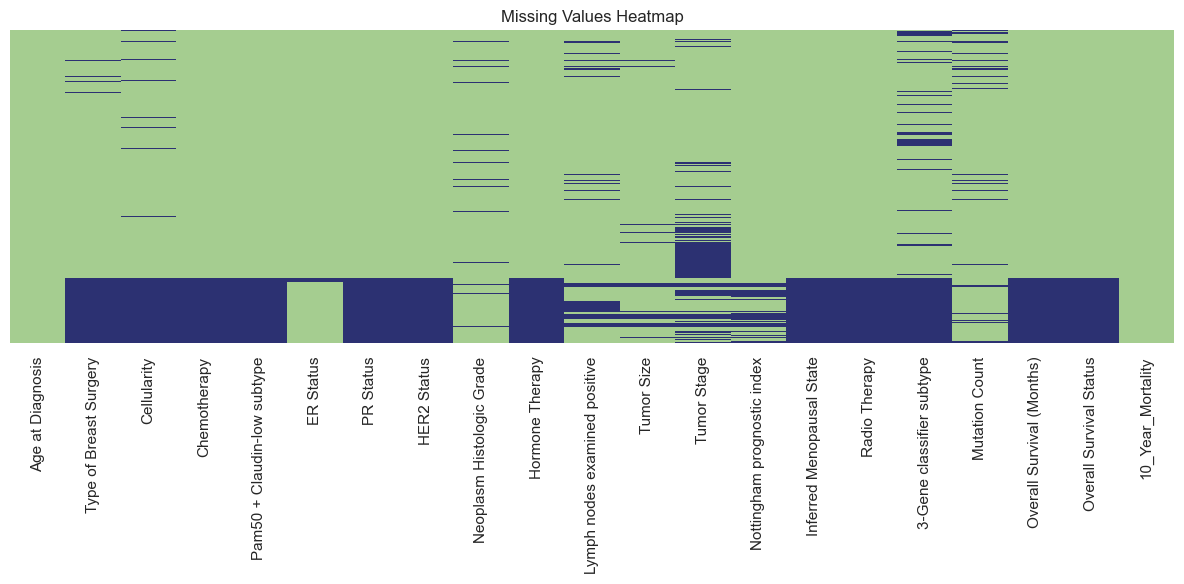

In [29]:
# --- 2. Load and Clean Data ---

# Load dataset and subset clinically relevant features
# df = pd.read_csv("Breast Cancer METABRIC.csv")
df = pd.read_csv(r"D:\BIA\Capstone Project\Breast Cancer METABRIC.csv")

# Select relevant clinical and genomic features based on medical context
selected_features = [
    'Age at Diagnosis', 'Type of Breast Surgery', 'Cellularity', 'Chemotherapy',
    'Pam50 + Claudin-low subtype', 'ER Status', 'PR Status', 'HER2 Status',
    'Neoplasm Histologic Grade', 'Hormone Therapy', 'Lymph nodes examined positive',
    'Tumor Size', 'Tumor Stage', 'Nottingham prognostic index', 'Inferred Menopausal State',
    'Radio Therapy', '3-Gene classifier subtype', 'Mutation Count',
    'Overall Survival (Months)', 'Overall Survival Status'
]
df = df[selected_features].copy()

# Create binary target: 1 if deceased within 10 years, else 0
df['10_Year_Mortality'] = ((df['Overall Survival (Months)'] <= 120) &
                           (df['Overall Survival Status'] == 'Deceased')).astype(int)

# --- Visualize Missing Values ---
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="crest", yticklabels=False)
plt.title("Missing Values Heatmap")
plt.tight_layout()
plt.savefig("PPT/missing_values_heatmap.png")
plt.show()


✅ Impute Missing Values

In [30]:
# --- 3. Impute Missing Values ---

# Define feature types
numerical_features = [
    'Age at Diagnosis', 'Lymph nodes examined positive', 'Tumor Size',
    'Nottingham prognostic index', 'Mutation Count'
]

categorical_features = [
    'Type of Breast Surgery', 'Cellularity', 'Chemotherapy', 'Pam50 + Claudin-low subtype',
    'ER Status', 'PR Status', 'HER2 Status', 'Neoplasm Histologic Grade',
    'Hormone Therapy', 'Tumor Stage', 'Inferred Menopausal State', 'Radio Therapy',
    '3-Gene classifier subtype'
]

# Median imputation for numeric fields
numerical_imputer = SimpleImputer(strategy='median')
df[numerical_features] = numerical_imputer.fit_transform(df[numerical_features])

# Mode imputation for categorical fields
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])


✅ Cap Outliers

In [31]:
# --- 4. Outlier Capping ---

# Function to cap outliers using IQR
def cap_outliers(column):
    Q1, Q3 = df[column].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower, upper=upper)

# Apply outlier capping
for col in numerical_features:
    cap_outliers(col)


✅ EDA – Histograms & Count Plots

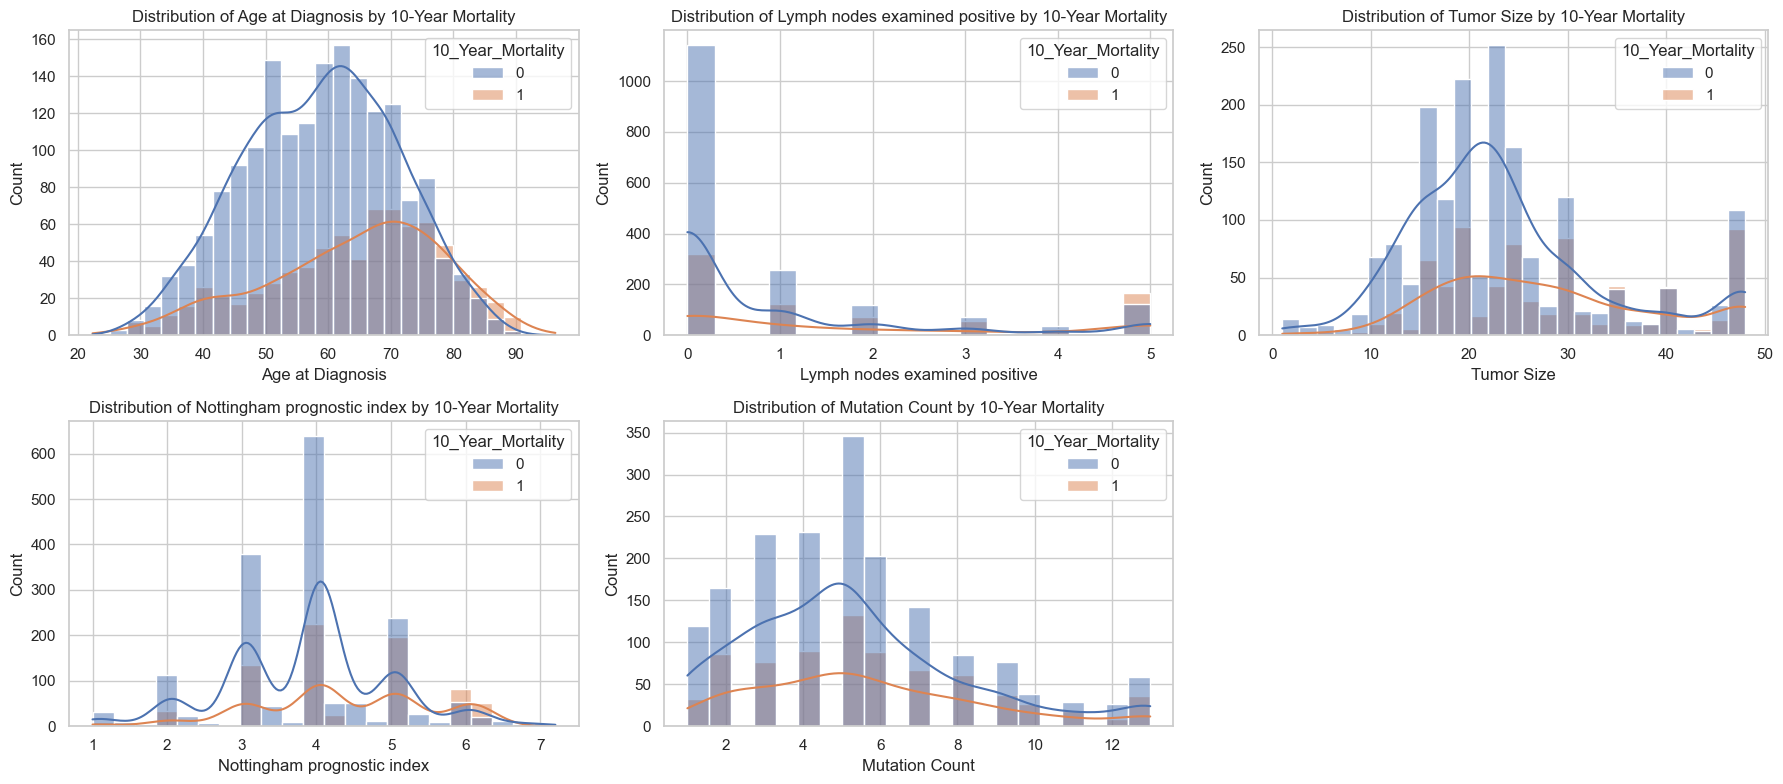

<Figure size 640x480 with 0 Axes>

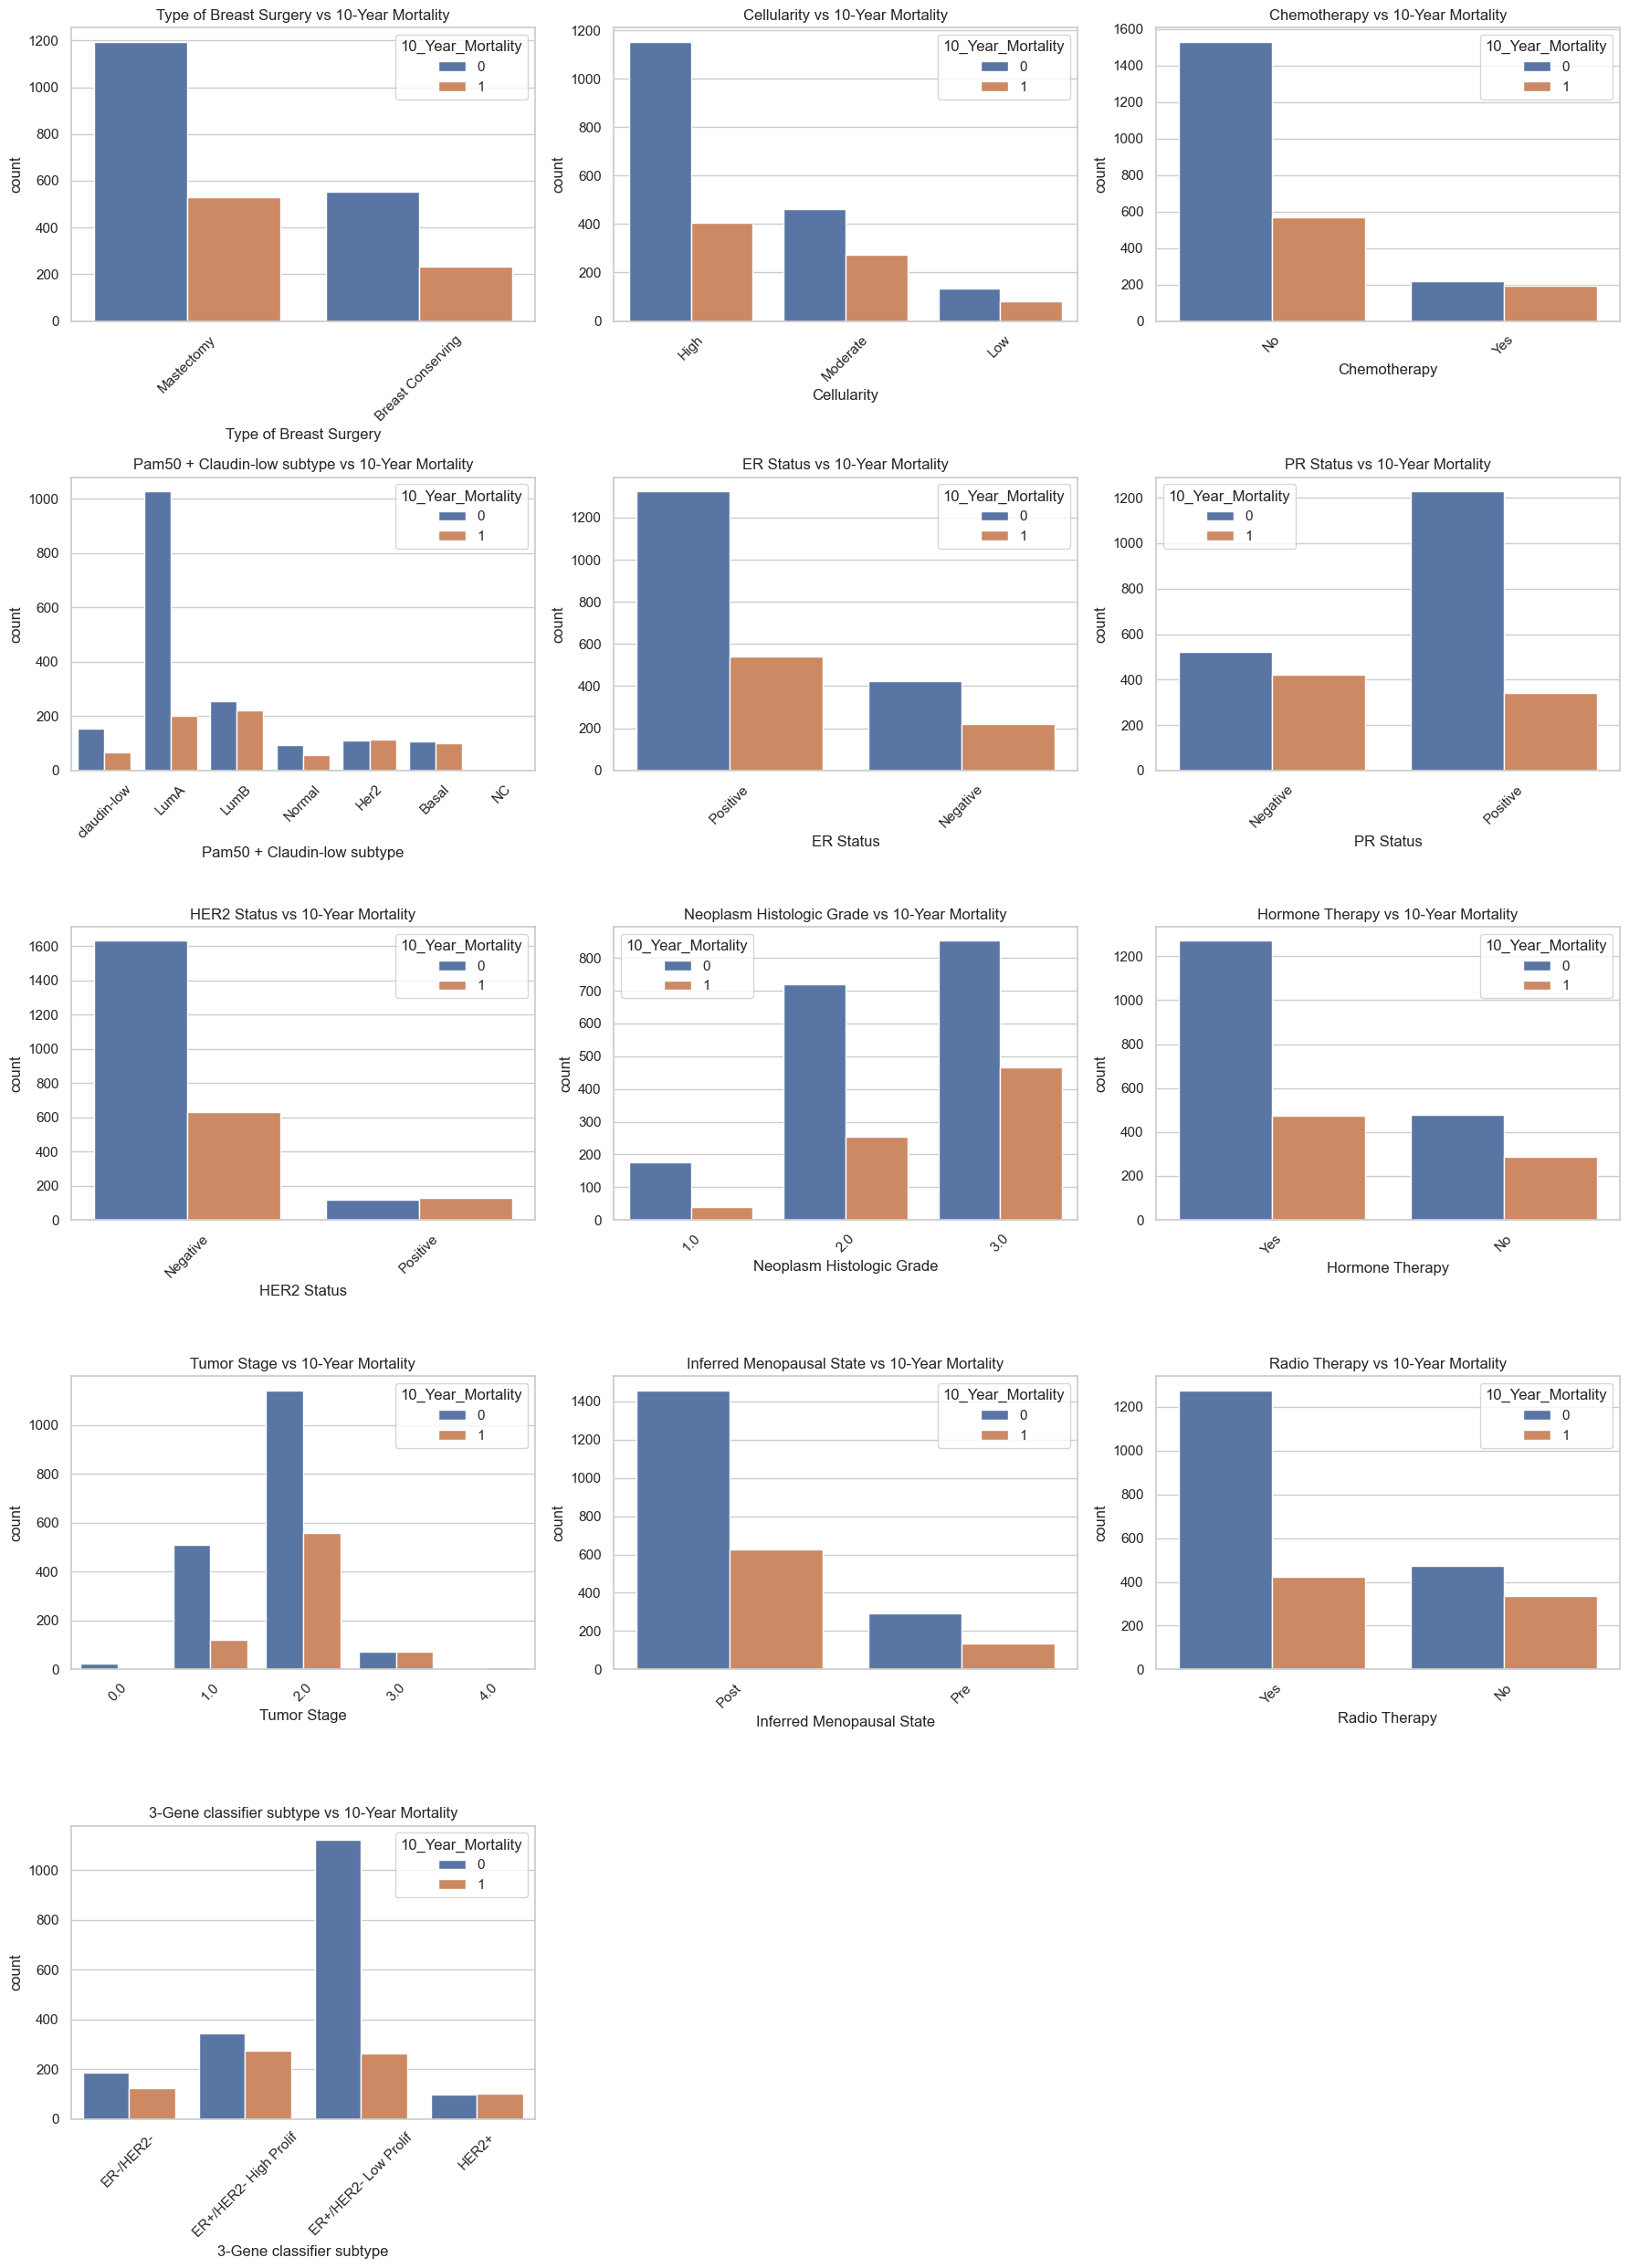

<Figure size 640x480 with 0 Axes>

In [32]:
# --- 5. EDA Relationships ---

# Assuming `numerical_features` is a list of your numeric column names

# Histograms for numeric features by mortality
n_cols = 3  # Number of subplots per row
n_rows = math.ceil(len(numerical_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.histplot(data=df, x=col, hue='10_Year_Mortality', kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col} by 10-Year Mortality")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
plt.savefig('PPT/numerical_features.png')


# Assuming `categorical_features` is a list of your categorical column names

n_cols = 3  # Number of plots per row
n_rows = math.ceil(len(categorical_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.countplot(data=df, x=col, hue='10_Year_Mortality', ax=axes[i])
    axes[i].set_title(f"{col} vs 10-Year Mortality")
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel(col)

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
plt.savefig('PPT/categorical_features.png')

✅ Correlation Heatmap

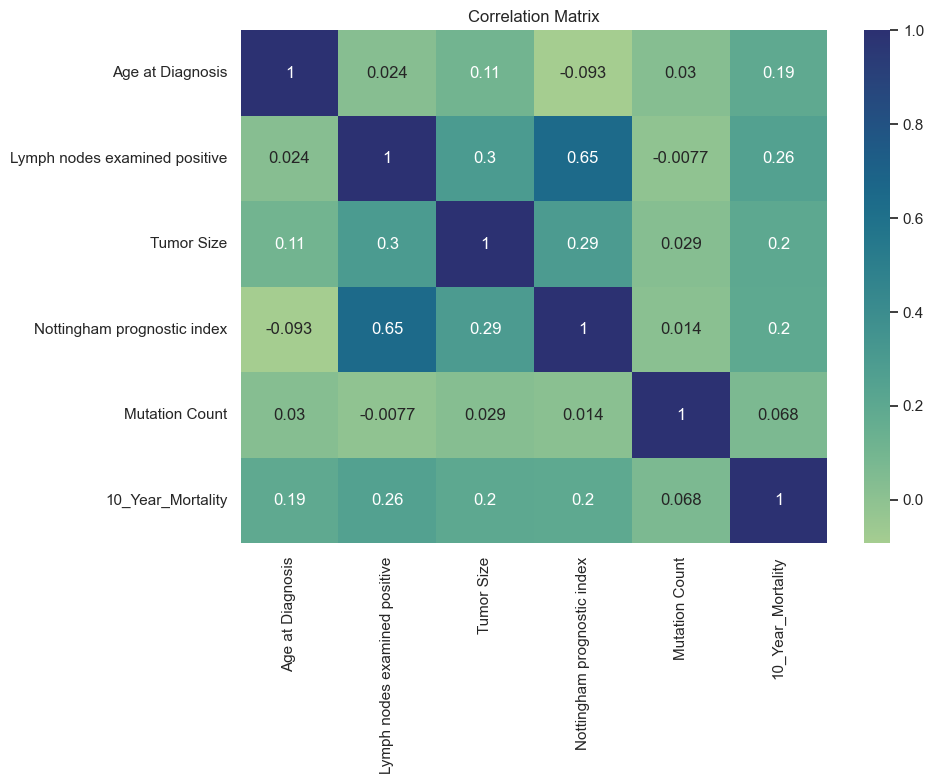

<Figure size 640x480 with 0 Axes>

In [33]:
# --- 6. Correlation Heatmap ---
# Visualize correlation to identify linear associations between numerical features and target

plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features + ['10_Year_Mortality']].corr(), annot=True, cmap='crest')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()
plt.savefig('PPT/Correlation.png')

✅ Feature Encoding

In [34]:
# --- 7. Encode Features ---
# Standardize numerical features, label encode ordinal features, and one-hot encode nominal features

# Standardize numerical features
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Encode ordinal features using LabelEncoder
ordinal_features = ['Tumor Stage', 'Neoplasm Histologic Grade']
label_encoders = {}
for col in ordinal_features:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# One-hot encode nominal features
nominal_features = [col for col in categorical_features if col not in ordinal_features]
df_encoded = pd.get_dummies(df[nominal_features], drop_first=True)
nominal_dummy_columns = df_encoded.columns.tolist()

✅ Prepare Dataset & Select Features

In [35]:
# --- 8. Prepare Final Dataset ---

X_full = pd.concat([df[numerical_features + ordinal_features], df_encoded], axis=1)
y = df['10_Year_Mortality']

In [36]:
# --- 9. Feature Selection ---
# Select top 20 statistically significant features using ANOVA F-test

selector = SelectKBest(score_func=f_classif, k=20)
X_selected = selector.fit_transform(X_full, y)
selected_columns = X_full.columns[selector.get_support()]
print("Top 20 selected features:", selected_columns.to_list())

X = X_full[selected_columns]

# Stratified train-test split to preserve target distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Top 20 selected features: ['Age at Diagnosis', 'Lymph nodes examined positive', 'Tumor Size', 'Nottingham prognostic index', 'Mutation Count', 'Tumor Stage', 'Neoplasm Histologic Grade', 'Cellularity_Low', 'Cellularity_Moderate', 'Chemotherapy_Yes', 'Pam50 + Claudin-low subtype_Her2', 'Pam50 + Claudin-low subtype_LumA', 'Pam50 + Claudin-low subtype_LumB', 'PR Status_Positive', 'HER2 Status_Positive', 'Hormone Therapy_Yes', 'Radio Therapy_Yes', '3-Gene classifier subtype_ER+/HER2- Low Prolif', '3-Gene classifier subtype_ER-/HER2-', '3-Gene classifier subtype_HER2+']


✅ Train Models


Logistic Regression Cross-Validation and Tuning:
Best Params: {'C': 0.1}
Best CV Score: 0.7882
Test AUC: 0.803
Test F1 Score: 0.602
              precision    recall  f1-score   support

           0       0.86      0.70      0.77       350
           1       0.51      0.73      0.60       152

    accuracy                           0.71       502
   macro avg       0.68      0.71      0.69       502
weighted avg       0.75      0.71      0.72       502


SVM Cross-Validation and Tuning:
Best Params: {'C': 1, 'kernel': 'rbf'}
Best CV Score: 0.7937
Test AUC: 0.794
Test F1 Score: 0.594
              precision    recall  f1-score   support

           0       0.86      0.68      0.76       350
           1       0.50      0.74      0.59       152

    accuracy                           0.70       502
   macro avg       0.68      0.71      0.68       502
weighted avg       0.75      0.70      0.71       502


Decision Tree Cross-Validation and Tuning:
Best Params: {'max_depth': 3}
Best CV

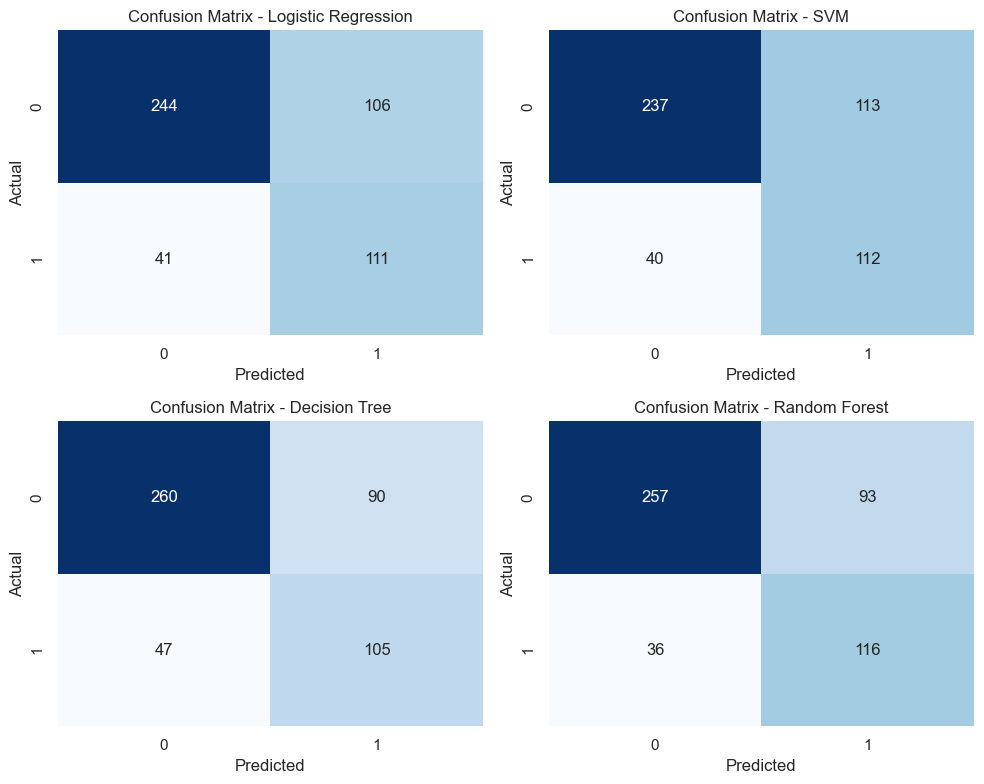

In [37]:
# --- 10. Model Training using Cross validation and Hyperparameter Tuning ---

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model definitions and tuning grids
model_params = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'params': {'C': [0.01, 0.1, 1, 10]}
    },
    'SVM': {
        'model': SVC(probability=True, class_weight='balanced'),
        'params': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(class_weight='balanced'),
        'params': {'max_depth': [3, 5, 7, None]}
    },
    'Random Forest': {
        'model': RandomForestClassifier(class_weight='balanced', random_state=42),
        'params': {'n_estimators': [50, 100], 'max_depth': [5, 10, None]}
    }
}

results = {}
comparison_metrics = []

# Model training and evaluation
for name, config in model_params.items():
    print(f"\n{name} Cross-Validation and Tuning:")
    gs = GridSearchCV(config['model'], config['params'], cv=cv, scoring='roc_auc', n_jobs=-1)
    gs.fit(X_train, y_train)
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate Metrics
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results
    results[name] = {
        'model': best_model,
        'auc': auc,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'best_params': gs.best_params_,
        'best_score': gs.best_score_
    }

    # Print summary
    print(f"Best Params: {gs.best_params_}")
    print(f"Best CV Score: {gs.best_score_:.4f}")
    print(f"Test AUC: {auc:.3f}")
    print(f"Test F1 Score: {f1:.3f}")
    print(classification_report(y_test, y_pred))

    # Store comparison table metrics
    comparison_metrics.append({
        'Model': name,
        'Accuracy': acc,
        'AUC': auc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'Best Params': gs.best_params_,
        'CV AUC': gs.best_score_
    })

# --- Confusion Matrices ---

model_names = list(results.keys())
n_models = len(model_names)
n_cols = 2
n_rows = (n_models + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

for idx, name in enumerate(model_names):
    cm = confusion_matrix(y_test, results[name]['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False)
    axes[idx].set_title(f"Confusion Matrix - {name}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

# Hide unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("PPT/confusion_matrices_combined.png")
plt.show()


In [38]:
# --- 11. Model Comparison Table ---

comparison_df = pd.DataFrame(comparison_metrics)
comparison_df.set_index("Model", inplace=True)
print("\nModel Comparison Summary:")
print(comparison_df)
comparison_df.to_csv("PPT/model_comparison_summary.csv")



Model Comparison Summary:
                     Accuracy       AUC  Precision    Recall  F1 Score  \
Model                                                                    
Logistic Regression  0.707171  0.802782   0.511521  0.730263  0.601626   
SVM                  0.695219  0.794286   0.497778  0.736842  0.594164   
Decision Tree        0.727092  0.777632   0.538462  0.690789  0.605187   
Random Forest        0.743028  0.821673   0.555024  0.763158  0.642659   

                                               Best Params    CV AUC  
Model                                                                 
Logistic Regression                             {'C': 0.1}  0.788208  
SVM                              {'C': 1, 'kernel': 'rbf'}  0.793695  
Decision Tree                             {'max_depth': 3}  0.747945  
Random Forest        {'max_depth': 5, 'n_estimators': 100}  0.795311  


✅ Visualizations (Confusion, ROC, Feature Importance)

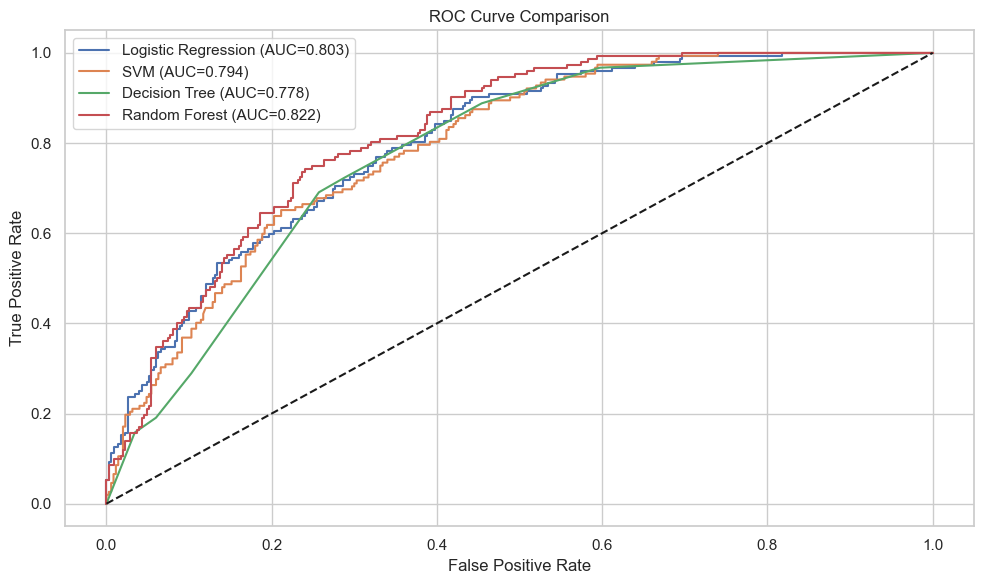

<Figure size 640x480 with 0 Axes>

In [39]:
# --- 12. ROC Curve ---
# Plot ROC curves to compare classifier performance visually

plt.figure(figsize=(10, 6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_prob'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={res['auc']:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('PPT/roc_curve.png')

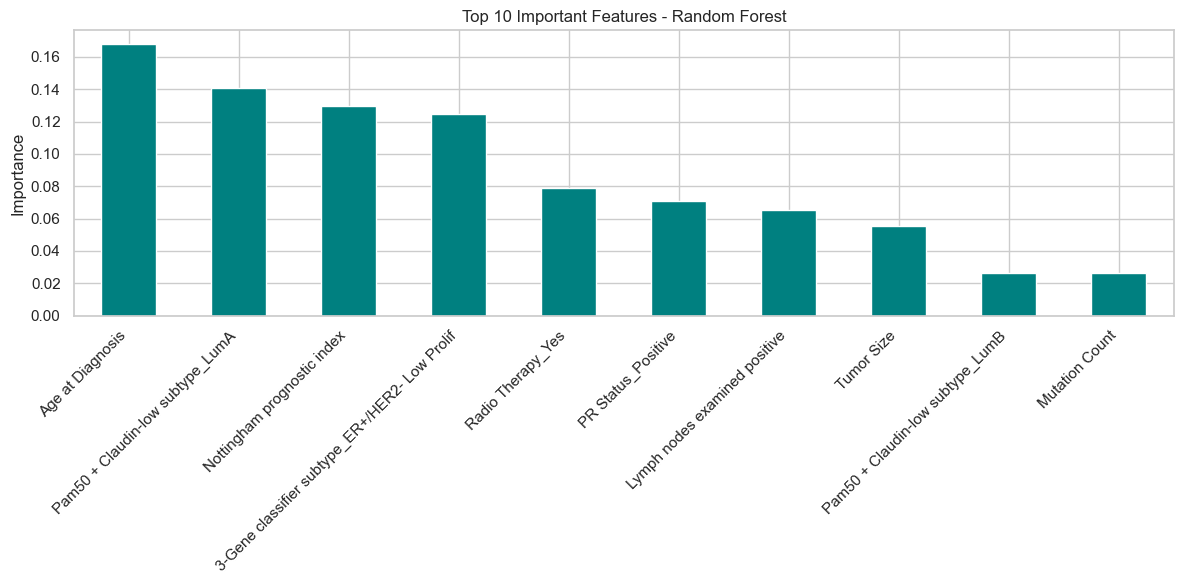

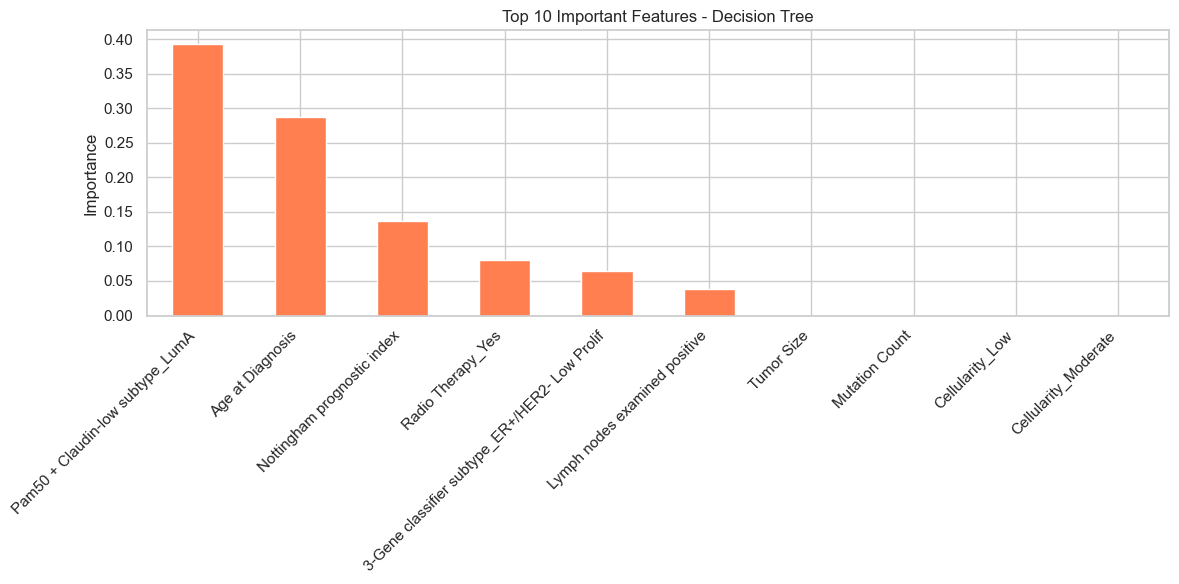

In [40]:
# --- 13. Feature Importance ---
# Display top 10 important features

# --- Random Forest Feature Importance ---
rf_model = results['Random Forest']['model']
rf_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
rf_importance[:10].plot(kind='bar', color='teal')
plt.title("Top 10 Important Features - Random Forest")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('PPT/Feature_Importance_RandomForest.png')
plt.show()

# --- Decision Tree Feature Importance ---
dt_model = results['Decision Tree']['model']
dt_importance = pd.Series(dt_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
dt_importance[:10].plot(kind='bar', color='coral')
plt.title("Top 10 Important Features - Decision Tree")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('PPT/Feature_Importance_DecisionTree.png')
plt.show()



✅ Kaplan-Meier and Cox PH Analysis

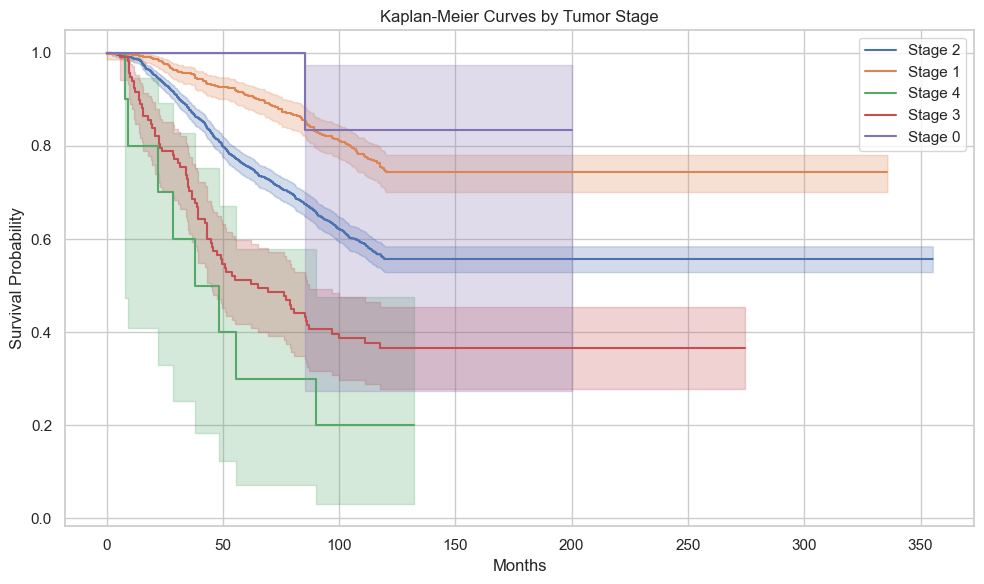

<Figure size 640x480 with 0 Axes>

In [41]:
# --- 14. Kaplan-Meier Curve by Tumor Stage ---
# Estimate survival curves stratified by tumor stage using Kaplan-Meier estimator

kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
for stage in df['Tumor Stage'].unique():
    mask = df['Tumor Stage'] == stage
    stage_df = df.loc[mask, ['Overall Survival (Months)', '10_Year_Mortality']].dropna()
    if not stage_df.empty:
        kmf.fit(stage_df['Overall Survival (Months)'],
                event_observed=stage_df['10_Year_Mortality'],
                label=f"Stage {stage}")
        kmf.plot()
plt.title("Kaplan-Meier Curves by Tumor Stage")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('PPT/Kaplan-Meier_Curve.png')

<lifelines.CoxPHFitter: fitted with 1981 total observations, 1221 right-censored observations>
             duration col = 'Overall Survival (Months)'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1981
number of events observed = 760
   partial log-likelihood = -5341.25
         time fit was run = 2025-07-04 14:01:06 UTC

---
                                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                       
Age at Diagnosis                                0.54      1.71      0.06            0.42            0.65                1.52                1.92
Lymph nodes examined positive                   0.25      1.28      0.05            0.15            0.35                1.16                1.42
Tumor Size                                      0.14      1.15      0.04            0.06            0.21                1.06                1.24
Nottingham prognostic index                     0.11      1.11      0.07           -0.03            0.24                0.97                1.27
Mutation Count                                  0.02      1.02      0.04           -0.05            0.09                0.95                1.09
Tumor Stage                                     0.17      1.18      0.08            0.00            0.33                1.00                1.40
Neoplasm Histologic Grade                       0.10      1.11      0.08           -0.06            0.27                0.94                1.31
Type of Breast Surgery_Mastectomy               0.07      1.07      0.09           -0.12            0.25                0.89                1.29
Cellularity_Low                                 0.18      1.19      0.13           -0.08            0.43                0.93                1.53
Cellularity_Moderate                            0.08      1.09      0.08           -0.08            0.24                0.93                1.27
Chemotherapy_Yes                                0.20      1.22      0.12           -0.04            0.44                0.96                1.56
Pam50 + Claudin-low subtype_Her2               -0.12      0.89      0.16           -0.44            0.20                0.65                1.22
Pam50 + Claudin-low subtype_LumA               -0.32      0.73      0.18           -0.68            0.05                0.51                1.05
Pam50 + Claudin-low subtype_LumB               -0.02      0.98      0.19           -0.38            0.35                0.68                1.42
Pam50 + Claudin-low subtype_NC                 -0.10      0.91      0.61           -1.29            1.09                0.28                2.97
Pam50 + Claudin-low subtype_Normal              0.05      1.06      0.20           -0.35            0.45                0.71                1.58
Pam50 + Claudin-low subtype_claudin-low        -0.40      0.67      0.16           -0.72           -0.07                0.49                0.93
ER Status_Positive                             -0.44      0.65      0.16           -0.75           -0.12                0.47                0.88
PR Status_Positive                             -0.18      0.84      0.09           -0.35            0.00                0.70                1.00
HER2 Status_Positive                            0.21      1.24      0.17           -0.12            0.55                0.89                1.73
Hormone Therapy_Yes                            -0.22      0.80      0.09           -0.40           -0.04                0.67                0.96
Inferred Menopausal State_Pre                   0.46      1.58      0.14            0.18            0.74                1.19                2.09
Radio Therapy_Yes                              -0.27      0.76      0.09           -0.45           -0.09                0.64              

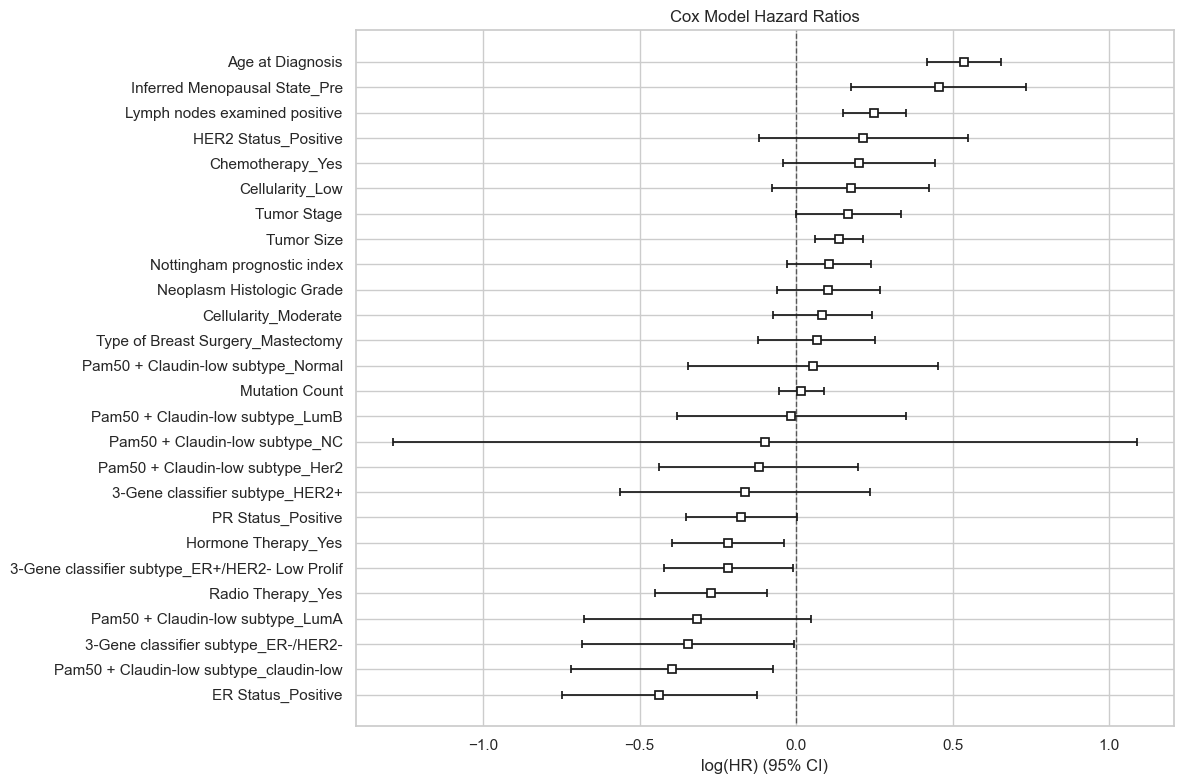

<Figure size 640x480 with 0 Axes>

In [42]:
# --- 15. Cox Proportional Hazards ---
# Fit multivariate Cox model to evaluate feature impact on survival time

cox_df = df[[
    'Overall Survival (Months)', '10_Year_Mortality'
] + numerical_features + ordinal_features + nominal_features]
cox_df = pd.get_dummies(cox_df, drop_first=True)
cox_df = cox_df.dropna()
cox_df.rename(columns={'10_Year_Mortality': 'event'}, inplace=True)

cph = CoxPHFitter()
cph.fit(cox_df, duration_col='Overall Survival (Months)', event_col='event')
cph.print_summary()

plt.figure(figsize=(12, 8))
cph.plot()
plt.title("Cox Model Hazard Ratios")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('PPT/Cox_Proportional.png')

✅ Save Model and Predict Function

In [43]:
# # --- 16. Save Models ---
# # Persist models and preprocessing objects for deployment

joblib.dump(results['Logistic Regression']['model'], 'logistic_model.pkl')
joblib.dump(results['Random Forest']['model'], 'rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(selected_columns.tolist(), 'selected_columns.pkl')


['selected_columns.pkl']

In [44]:
# --- 17. Example Prediction ---
# Define reusable function for single-patient mortality risk prediction

def predict_mortality_risk(patient_data, model_name='Random Forest'):
    patient_df = pd.DataFrame([patient_data])
    

    # Scale numerical features
    patient_df[numerical_features] = scaler.transform(patient_df[numerical_features])

    # Encode ordinal features
    for col in ordinal_features:
        le = label_encoders[col]
        value = str(patient_df[col].values[0])
        if value in le.classes_:
            patient_df[col] = le.transform([value])
        else:
            patient_df[col] = -1

    # Encode nominal features
    patient_encoded = pd.get_dummies(patient_df[nominal_features], drop_first=True)
    for col in nominal_dummy_columns:
        if col not in patient_encoded:
            patient_encoded[col] = 0

    # Combine all features
    final_input = pd.concat([patient_df[numerical_features + ordinal_features], patient_encoded], axis=1)
    final_input = final_input.reindex(columns=selected_columns, fill_value=0)

    # Load model and predict
    model = results[model_name]['model']
    prob = model.predict_proba(final_input)[0][1]
    risk = 'Low' if prob < 0.3 else 'Medium' if prob < 0.7 else 'High'
    
    # Accuracy from results dict (calculated during evaluation phase)
    accuracy = (results[model_name]['y_pred'] == y_test).mean()

    return {
        'probability': prob,
        'risk_level': risk,
        'accuracy': accuracy,
        'model': model_name
    }
# --- 15. Example Prediction ---
example = {
    'Age at Diagnosis': 55, 'Lymph nodes examined positive': 2, 'Mutation Count': 30,
    'Nottingham prognostic index': 4.5, 'Tumor Size': 25,
    'Tumor Stage': '2', 'Neoplasm Histologic Grade': '2',
    'Type of Breast Surgery': 'BREAST CONSERVING', 'Chemotherapy': 'YES',
    'ER Status': 'Positive', 'PR Status': 'Positive', 'HER2 Status': 'Negative',
    'Hormone Therapy': 'YES', 'Cellularity': 'Moderate', 'Pam50 + Claudin-low subtype': 'Luminal A',
    'Radio Therapy': 'YES', 'Inferred Menopausal State': 'Post', '3-Gene classifier subtype': 'ER-/HER2-'
}


result = predict_mortality_risk(example)
print("\nExample Prediction:")
print(f"Model: {result['model']}")
print(f"10-Year Mortality Probability: {result['probability']:.1%}")
print(f"Risk Level: {result['risk_level']}")
print(f"Model Accuracy: {result['accuracy']:.2%}")



Example Prediction:
Model: Random Forest
10-Year Mortality Probability: 57.8%
Risk Level: Medium
Model Accuracy: 74.30%


## Conclusion

In this survival analysis ML model, developed a robust pipeline to analyze and predict breast cancer 10-year mortality using the METABRIC dataset. 
The workflow included:

- Clinical feature selection and data cleaning.
- Exploratory analysis and survival modeling.
- Machine learning classification using multiple models.
- Feature importance interpretation and ROC curve visualization.
- Model serialization and deployment-ready prediction function.

This model can serve as a clinical decision support tool to assist oncologists in identifying high-risk patients and tailoring follow-up or treatment accordingly. Future work may include integrating genomic signatures, temporal survival models, and external dataset validation.
